In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Read all the words
words = open('C:/Users/pchavan/The Bridge/MLStuff/makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
#build the vocabulary of characters and mapping to/from integers    
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
#build the dataset

block_size = 3 #how many charaters we are going to use to predict next

X, Y = [], []

for w in words[:5]:
    print(w)

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]    #Crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [11]:
C = torch.randn((27, 2))

In [36]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [37]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [61]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [59]:
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [62]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [63]:
logits = h @ W2 + b2

In [64]:
logits.shape

torch.Size([32, 27])

In [66]:
counts = logits.exp()

In [67]:
prob = counts / counts.sum(1, keepdim=True)

In [68]:
prob.shape

torch.Size([32, 27])

In [69]:
prob[torch.arange(32), Y]

tensor([1.5247e-01, 1.5480e-09, 5.9448e-08, 1.7164e-04, 1.0651e-09, 3.9425e-10,
        3.2549e-06, 2.0517e-04, 2.1025e-06, 3.3635e-01, 1.5026e-06, 5.9409e-09,
        4.5116e-08, 1.1249e-05, 4.1868e-03, 7.6190e-07, 7.7680e-08, 3.8413e-02,
        1.5355e-11, 1.1243e-06, 9.9457e-01, 7.8317e-08, 7.5691e-07, 2.4721e-05,
        1.2317e-05, 8.6063e-05, 4.6403e-08, 9.4100e-07, 3.2411e-08, 8.5429e-07,
        2.7738e-04, 9.7885e-03])

In [70]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [71]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [73]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(12.5019)

In [74]:
# ------------- Putting all togather ----------------#

In [271]:
# Splitting Data

#build the dataset
def build_dataset(words):
    block_size = 3 #how many charaters we are going to use to predict next

    X, Y = [], []

    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]    #Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [272]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182580, 3]), torch.int64, torch.Size([182580]), torch.int64)

In [280]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [281]:
sum(p.nelement() for p in parameters)

11897

In [282]:
for p in parameters:
    p.requires_grad = True

In [283]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [287]:
stepi, lossi = [],[]
itr = 100000
lr_update = itr/1000

for i in range(itr):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    #Forward Pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])    
    # print(loss.item())

    #Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update 
    # lr = lrs[i]

    if i % lr_update == 0:
        lr = lrs[-(int(i/lr_update) + 1)]
    for p in parameters:
        p.data += -lr * p.grad

    #track Stat
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)
        
# print(loss.item())

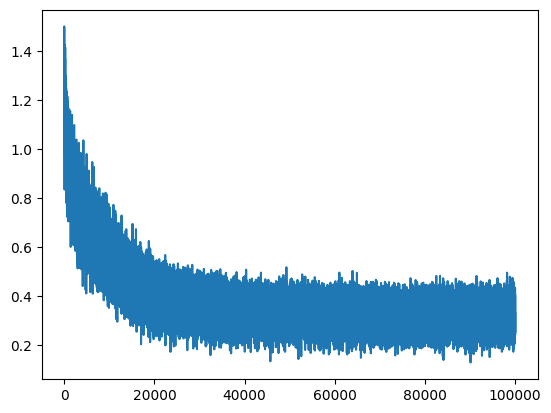

In [285]:
plt.plot(stepi, lossi)

In [288]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)    
print(loss.item())

2.1784143447875977


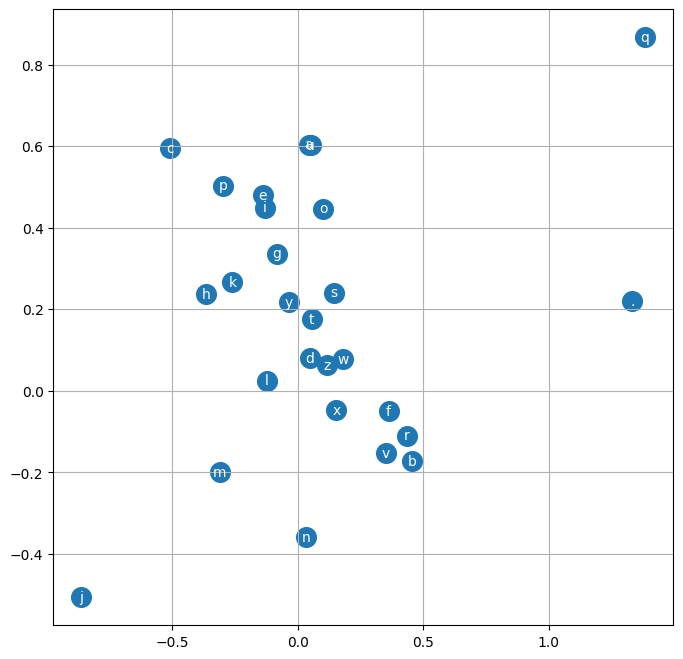

In [220]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid('minor')

In [ ]:
#Sample from model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initalizing with all ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
ndyn.
alee.
thracendraeg.
adelynneliigh.
porelle.
elieananar.
elle.
malara.
noshibergihi.
jest.
jairenlynn.
nohustous.
mace.
ryyah.
fael.
yuma.
mysanyah.


tensor(1.)